We only include phonemes from classes with >50 items, i.e.: 
[  3.   9.  11.  12.  17.  18.  20.  21.  22.  23.  27.  28.  29.  31.]
Range of the data (after scaling): -111.9 to 125.24 mean/median: 9.83280376431e-08 / 0.216055
32 5 25
Size of original (single-chunked) data: (1378, 1024)
Size of encoded data: (1378, 800)
Distance matrices for encoded data (rightmost column indicates classes, color-coded)


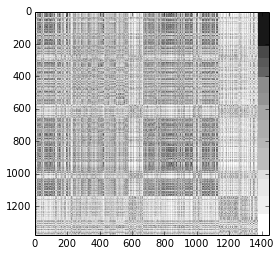

Distance matrices for raw data (rightmost column indicates classes, color-coded)


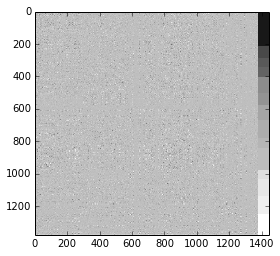

Successful classification rate with encoded data:  0.438316400581
Successful classification rate with raw data:  0.201741654572
Successful classification rate with shuffled guesses from encoded data (as a control):  0.088534107402
Confusion matrix for classification from encoded data:


/Users/tminconi/Library/Python/2.7/lib/python/site-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


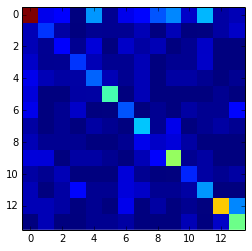

In [1]:
# We want to test whether the encoder produces "usable" representations of sound. 

# To do this, we classify phonemes from the "Phoneme" dataset in the UCR base. We use both raw and encoded data.

# We show that the encoded data results in much better phoneme classification performance than the raw data, both on
# linear SVM and K nearest neighbors, despite being smaller in size.

import sys
import sklearn
from frequency_encoder import FrequencyEncoder
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

fulldata = np.loadtxt('./UCR_TS_Archive_2015/Phoneme/Phoneme_TEST', delimiter=',')


data = fulldata[:, 1:]     
classes = fulldata[:, 0]
c, counts = np.unique(classes, return_counts=True)
cthresh = c[counts>50]    
print "We only include phonemes from classes with >50 items, i.e.: " 
print cthresh


#Scaling up the data to better take advantage of the log-transform in FrequencyEncoder 
#(See help message in FrequencyEncoder, and also next cell in this notebook)
data = 10 * data
print "Range of the data (after scaling):", np.min(data), "to", np.max(data), "mean/median:",np.mean(data), "/", np.median(data)



# This is a loop to facilitate adding and comparing more parameter values. 
# Here, we only use one set of parameters, so there is only one iteration in each loop.
for numfreqbins in (32,):   # Number of frequency bins
    for (freqbinW, freqbinN) in ((5,25),):   # ScalarEncoder parameters W and N

        print numfreqbins, freqbinW, freqbinN
        minvalpow = 0.0
        maxvalpow = 12.0  

        encoder = FrequencyEncoder(numfreqbins, freqbinN, freqbinW, minvalpow, maxvalpow)


        # We extract the data from classes with more than 50 instances
        datasmall = data[np.in1d(classes, cthresh), :]
        classessmall = classes[np.in1d(classes, cthresh)==True]

        # We use each entire phoneme as one big chunk
        timechunksize = 1024
        StartPoint=0

        datasinglechunk = datasmall[:, StartPoint:StartPoint+timechunksize]

        # Encoding the data!
        encodeddata=[]
        for n in range(datasinglechunk.shape[0]):
            t = encoder.encode(datasinglechunk[n,:])
            #encodeddata.append(t[:len(t)/2])
            encodeddata.append(t)

        encodeddata = np.array(encodeddata)
        print "Size of original (single-chunked) data:", datasinglechunk.shape
        print "Size of encoded data:", encodeddata.shape

        #cmraw = np.corrcoef(datasinglechunk)
        #Y = pdist(datasinglechunk)
        #cmraw = squareform(Y)
        #cmraw = cmraw - np.eye(cmraw.shape[0])

        #cmenc = np.corrcoef(encodeddata)
        #cmenc = cmenc - np.eye(cmenc.shape[0])
    
    
        # Let's show some distance matrices
        
        #Y = pdist(encodeddata, lambda u, v: (u+v == 2).sum() )  # Overlap of '1' bits
        Y = pdist(encodeddata)  # Euclidean distance
        cmenc = squareform(Y)
        cmenc = cmenc - np.min(cmenc)
        cmenc = cmenc / np.max(cmenc)
        #print cmraw.shape, cmenc.shape
        
        Y = pdist(datasinglechunk)  # Euclidean distance
        cmraw = squareform(Y)
        cmraw = cmraw - np.min(cmraw)
        cmraw = cmraw / np.max(cmraw)
        
        print "Distance matrices for encoded data (rightmost column indicates classes, color-coded)"
        plt.imshow(np.append(cmenc, np.tile(classessmall[:, None], (1, 70))/31.0, axis=1), cmap='gray', interpolation='none')
        plt.show()
        
        print "Distance matrices for raw data (rightmost column indicates classes, color-coded)"
        plt.imshow(np.append(cmraw, np.tile(classessmall[:, None], (1, 70))/31.0, axis=1), cmap='gray', interpolation='none')
        plt.show()

        
        # Classification 
        
        #model = LinearSVC()
        #model = KNeighborsClassifier(n_neighbors=1)
        modelenc = KNeighborsClassifier()  # 5-NN
        modelenc.fit(encodeddata[::2,:], classessmall[::2])
        guessesenc = modelenc.predict(encodeddata[1::2,:])
        print "Successful classification rate with encoded data: ", np.mean(guessesenc == classessmall[1::2])
        
        modelraw = KNeighborsClassifier()  # 5-NN
        modelraw.fit(datasinglechunk[::2,:], classessmall[::2])
        guessesraw = modelraw.predict(datasinglechunk[1::2,:])
        print "Successful classification rate with raw data: ", np.mean(guessesraw == classessmall[1::2])
        
        print "Successful classification rate with shuffled guesses from encoded data (as a control): ", np.mean(np.random.permutation(guessesenc) == classessmall[1::2])

        print "Confusion matrix for classification from encoded data:"
        plt.imshow(sklearn.metrics.confusion_matrix(guessesenc, classessmall[1::2]), interpolation='none')
        plt.show()

#Debugging notes:
# 10 3 15, 10 3 10, 10 5 15, 10 5 25
# With 5-KNN, full encodings, best classification perf all-classes (no scaling - scaling improves further)
# 32 11 64 (>.38 ! but note that the encoded data is now larger than the raw data)
# 64 11 64 > .36
# 64 11 30, 64 5 25, 32 11 30, 32 5 25 (> .34)
# 64 3 15, 20 11 30, 20 5 25, 20 11 64 (all > .33) !
# 64 5 15 > .32
# Also 10 11 64 > .31 20 3 15 10 11 30 10 5 25 > .29


We only include phonemes from 2 classes, i.e.: 
(23, 29)
32 5 25
Distance matrix for two classes of phonemes, encoded after scaling:


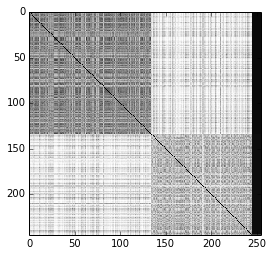

Distance matrix for two classes of phonemes, encoded without scaling:


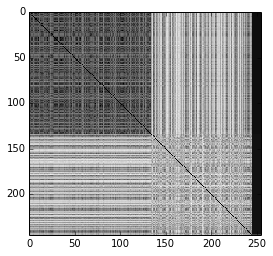

In [2]:
# Here we just show the distance matrix for two classes of phonemes, both with and without scaling. 

# This illustrates how up-scaling the data produces more discriminable encodings, presumably by 
# squashing the representation of higher energies 


fulldata = np.loadtxt('./UCR_TS_Archive_2015/Phoneme/Phoneme_TEST', delimiter=',')


data = fulldata[:, 1:]     
classes = fulldata[:, 0]
cthresh = (23, 29)
print "We only include phonemes from 2 classes, i.e.: " 
print cthresh


numfreqbins = 32
freqbinW = 5
freqbinN = 25
minvalpow = 0.0
maxvalpow = 12.0  
print numfreqbins, freqbinW, freqbinN


encoder = FrequencyEncoder(numfreqbins, freqbinN, freqbinW, minvalpow, maxvalpow)

datasmall = data[np.in1d(classes, cthresh), :]
classessmall = classes[np.in1d(classes, cthresh)==True]


# Again, data is encoded as one single chunk per phoneme

timechunksize = 1024
StartPoint=0
datasinglechunk = datasmall[:, StartPoint:StartPoint+timechunksize]



# First, without scaling :

encodeddata=[]
for n in range(datasinglechunk.shape[0]):
    encodeddata.append(encoder.encode(datasinglechunk[n,:]   *  10.0))  # Scaling up data before encoding
encodeddata = np.array(encodeddata)

Y = pdist(encodeddata)  # Euclidean distance
cmenc = squareform(Y)
print "Distance matrix for two classes of phonemes, encoded after scaling:"
plt.imshow(np.append(cmenc, np.tile(classessmall[:, None], (1, 10))/31.0, axis=1), cmap='gray', interpolation='none')
plt.show()


# Now without scaling:

# First, without scaling :

encodeddata=[]
for n in range(datasinglechunk.shape[0]):
    encodeddata.append(encoder.encode(datasinglechunk[n,:]))
encodeddata = np.array(encodeddata)

Y = pdist(encodeddata)  # Euclidean distance
cmenc = squareform(Y)
print "Distance matrix for two classes of phonemes, encoded without scaling:"
plt.imshow(np.append(cmenc, np.tile(classessmall[:, None], (1, 10))/31.0, axis=1), cmap='gray', interpolation='none')
plt.show()
